In [1]:
!pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 9.4 MB/s eta 0:00:00


In [ ]:
# Import libraries
import pandas as pd
from sklearn.model_selection import train_test_split
from catboost import CatBoostClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
from sklearn.utils.class_weight import compute_class_weight

# Grab the dataframe
df = pd.read_csv('flights.csv', low_memory=False)
df['Date'] = pd.to_datetime(df[['YEAR', 'MONTH', 'DAY']])
df['Schedule Delay'] = df['DEPARTURE_DELAY'] + df['ARRIVAL_DELAY']

# If it's NA, then the flight was cancelled
df.dropna(subset= ['DEPARTURE_DELAY', 'ARRIVAL_DELAY', 'Schedule Delay'], inplace = True)

# Convert the time
df['Scheduled Hour'] = (df['SCHEDULED_TIME'] // 100).astype(int)
df['Scheduled Arrival Time'] = (df['SCHEDULED_ARRIVAL'] // 100).astype(int)

# Categorize it, where 15m is usually considered the standard if a flight is delayed or not
df['Delayed or not'] = np.where(
    (df['DEPARTURE_DELAY'] < 15) & (df['ARRIVAL_DELAY'] < 15),
    'Not delayed',
    'Delayed'
)

print(df.head())

# Convert to 0 and 1
df['Is_Delayed'] = (df['Delayed or not'] == 'Delayed').astype(int)

# Add features for Catboost
X = df[['MONTH', 'DAY_OF_WEEK', 'DISTANCE', 'ORIGIN_AIRPORT', 'DESTINATION_AIRPORT', 'AIRLINE', 'Scheduled Hour', 'Scheduled Arrival Time']]
Y = df['Is_Delayed']

# 80-20 split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# Let it know which ones we want to be categorical
# Month and day of the week is since I want it to treat it as categorical instead
cat_features = ['MONTH', 'DAY_OF_WEEK', 'ORIGIN_AIRPORT', 'DESTINATION_AIRPORT', 'AIRLINE']

# Weight testing stuff, removed later on
n_negative = len(y_train[y_train == 0])
n_positive = len(y_train[y_train == 1])
scale_pos_weight = n_negative / n_positive


   YEAR  MONTH  DAY  DAY_OF_WEEK AIRLINE  FLIGHT_NUMBER TAIL_NUMBER  \
0  2015      1    1            4      AS             98      N407AS   
1  2015      1    1            4      AA           2336      N3KUAA   
2  2015      1    1            4      US            840      N171US   
3  2015      1    1            4      AA            258      N3HYAA   
4  2015      1    1            4      AS            135      N527AS   

  ORIGIN_AIRPORT DESTINATION_AIRPORT  SCHEDULED_DEPARTURE  ...  \
0            ANC                 SEA                    5  ...   
1            LAX                 PBI                   10  ...   
2            SFO                 CLT                   20  ...   
3            LAX                 MIA                   20  ...   
4            SEA                 ANC                   25  ...   

   AIR_SYSTEM_DELAY  SECURITY_DELAY  AIRLINE_DELAY  LATE_AIRCRAFT_DELAY  \
0               NaN             NaN            NaN                  NaN   
1               NaN       

In [ ]:
# Setup model
model = CatBoostClassifier(
    iterations=9999999,
    # Let the model pick
    # learning_rate = 0.01,
    depth = 6,
    l2_leaf_reg= 3,
    loss_function='Logloss',
    eval_metric='Logloss',
    early_stopping_rounds= 100,
    verbose=50,
    cat_features=cat_features,
    boosting_type='Plain',
    bootstrap_type='Poisson',
    auto_class_weights='Balanced',
    border_count=254,
    task_type="GPU"
)

# Fit the model
model.fit(X_train, y_train,
        eval_set=(X_test, y_test),
        verbose=50)

# Predict
y_pred = model.predict(X_test)

# Check accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")

# Check classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


0:	learn: 0.6889454	test: 0.6888602	best: 0.6888602 (0)	total: 106ms	remaining: 12d 7h 27m 21s
50:	learn: 0.6113128	test: 0.6109602	best: 0.6109602 (50)	total: 4.42s	remaining: 10d 39m 32s
100:	learn: 0.5951472	test: 0.5984974	best: 0.5984974 (100)	total: 5.8s	remaining: 6d 15h 33m 5s
150:	learn: 0.5859415	test: 0.5928910	best: 0.5928910 (150)	total: 6.75s	remaining: 5d 4h 7m 30s
200:	learn: 0.5796148	test: 0.5902118	best: 0.5902118 (200)	total: 7.72s	remaining: 4d 10h 41m
250:	learn: 0.5734725	test: 0.5878305	best: 0.5878305 (250)	total: 8.82s	remaining: 4d 1h 34m 41s
300:	learn: 0.5683446	test: 0.5865231	best: 0.5864875 (296)	total: 11.7s	remaining: 4d 11h 44m 22s
350:	learn: 0.5634020	test: 0.5850365	best: 0.5850003 (348)	total: 12.7s	remaining: 4d 4h 36m 54s
400:	learn: 0.5586674	test: 0.5838820	best: 0.5838820 (400)	total: 13.6s	remaining: 3d 22h 23m 38s
450:	learn: 0.5537846	test: 0.5830719	best: 0.5830417 (445)	total: 14.6s	remaining: 3d 18h 4m 25s
500:	learn: 0.5489471	test: 0.

In [ ]:
# Save the model
model.save_model('../model/catboost_model')

Text(50.722222222222214, 0.5, 'Actual Values ')

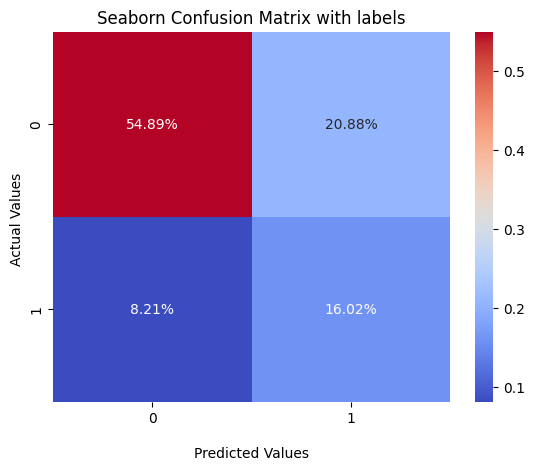

In [ ]:
# Import
import seaborn as sns

# Make a confusion matrix
conf_mat = confusion_matrix(y_test, y_pred)

# Convert it to percentages
ax = sns.heatmap(conf_mat / np.sum(conf_mat), annot = True, fmt='.2%', cmap = 'coolwarm')

# Set title & axis
ax.set_title('Seaborn Confusion Matrix with labels')
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ')